In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import operator
from prettytable import PrettyTable
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from collections import Counter, defaultdict
from bokeh.io import show, output_file
from bokeh.plotting import figure
import community
from networkx.drawing.nx_agraph import graphviz_layout

sns.set()
%matplotlib inline

## Load Data

In [2]:
dataset_dir = "/Users/rana/Documents/School/Spring23/Social Media Analytics-CS5664/Homeworks/Project/datasets"
print(os.listdir(dataset_dir))

['com-amazon.all.dedup.cmty.txt', '.DS_Store', 'amazon-meta.txt.gz', 'amazon-meta.txt', 'com-amazon.top5000.cmty.txt', 'products_data.csv', 'products_copurchases_links.csv', 'Amazon0302.txt', 'com-amazon.ungraph.txt']


In [3]:
product_data_file = "products_data.csv"
prod_path = os.path.join(dataset_dir, product_data_file)
df = pd.read_csv(prod_path, encoding="unicode_escape")

In [4]:
df.head()

,id,asin,title,group,salesrank,review_cnt,downloads,rating
0,1,0827229534,Patterns of Preaching: A Sermon Sampler,Book,396585,2,2,5.0
1,2,0738700797,Candlemas: Feast of Flames,Book,168596,12,12,4.5
2,3,0486287785,World War II Allied Fighter Planes Trading Cards,Book,1270652,1,1,5.0
3,4,0842328327,Life Application Bible Commentary: 1 and 2 Tim...,Book,631289,1,1,4.0
4,5,1577943082,Prayers That Avail Much for Business: Executive,Book,455160,0,0,0.0


In [5]:
product_links_file = "products_copurchases_links.csv"
prod_graph_path = os.path.join(dataset_dir, product_links_file)
df_graph = pd.read_csv(prod_graph_path, encoding="unicode_escape")

## Understanding Data

In [6]:
df_graph.head()

,source,destination
0,1,161555
1,1,244916
2,1,118052
3,1,444232
4,1,500600


In [7]:
df.shape

(542683, 8)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 542683 entries, 0 to 542682
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id          542683 non-null  int64  
 1   asin        542683 non-null  object 
 2   title       542683 non-null  object 
 3   group       542683 non-null  object 
 4   salesrank   542683 non-null  int64  
 5   review_cnt  542683 non-null  int64  
 6   downloads   542683 non-null  int64  
 7   rating      542683 non-null  float64
dtypes: float64(1), int64(4), object(3)
memory usage: 33.1+ MB


In [9]:
df["group"].unique()

array(['Book', 'Music', 'DVD', 'Video', 'Toy', 'Software', 'Baby', 'CE',
       'Sports', 'A'], dtype=object)

In [10]:
df["group"].value_counts()

Book        393560
Music       103143
Video        26132
DVD          19828
Toy              8
Software         5
CE               4
Baby             1
Sports           1
A                1
Name: group, dtype: int64

In [11]:
df['rating'].unique()

array([5. , 4.5, 4. , 0. , 3.5, 3. , 1. , 2.5, 2. , 1.5])

In [12]:
df['salesrank'].unique()

array([ 396585,  168596, 1270652, ...,  229742,   55228,       0])

In [13]:
df['salesrank'].value_counts()

-1          459
 0           40
 6516         9
 8895         9
 5926         9
           ... 
 415242       1
 404997       1
 2141076      1
 648700       1
 2047         1
Name: salesrank, Length: 411707, dtype: int64

In [14]:
df[df["salesrank"]==-1]

,id,asin,title,group,salesrank,review_cnt,downloads,rating
688,693,1853461822,Labour and Locality: Uneven Development and th...,Book,-1,0,0,0.0
1709,1727,0780357213,Vehicular Technology 51st Conference Proceedings,Book,-1,0,0,0.0
1817,1837,B00005663X,Uncovered,Music,-1,0,0,0.0
2596,2617,1880608014,DIMENSIONS OF FAITH,Book,-1,0,0,0.0
2972,2996,0467700036,Fracture Mechanics,Book,-1,0,0,0.0
...,...,...,...,...,...,...,...,...
505982,511781,0801848717,Mapping the Renaissance World,Book,-1,0,0,0.0
510065,515906,B00000II35,Love Existence,Music,-1,0,0,0.0
518460,524308,B0000037O4,Pussy King of the Pirates,Music,-1,7,7,3.5
527012,532869,0738519057,Napa County Wineries,Book,-1,3,3,5.0


we can drop products with (-1) sales rank which may not be helpful in our analysis

In [15]:
df = df.query("salesrank != -1")

In [16]:
df["salesrank"].min(), df["salesrank"].max()

(0, 3798351)

creating a dataframe for books where their sales rank is under 100000

In [17]:
df_books = df[
    (df["group"] == "Book") &
    (df["salesrank"] <= 100000)
]

In [18]:
df_books.shape

(51712, 8)

In [19]:
df_books['rating'].value_counts()

4.5    15858
5.0    14537
4.0    10461
3.5     4250
0.0     4063
3.0     1725
2.5      452
2.0      228
1.0       87
1.5       51
Name: rating, dtype: int64

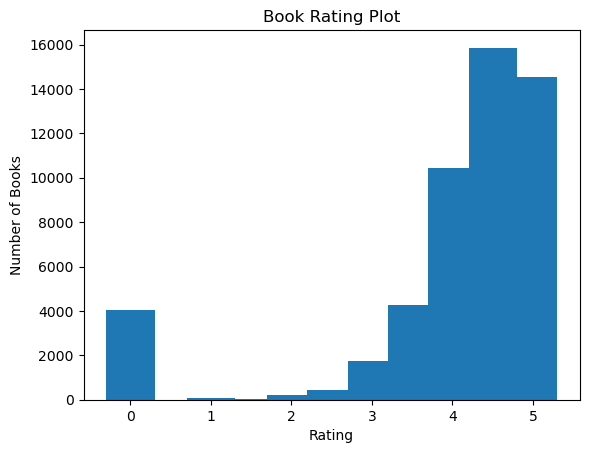

In [20]:
plt.title("Book Rating Plot")
plt.xlabel("Rating")
plt.ylabel("Number of Books")
plt.bar(dict(df_books['rating'].value_counts()).keys(), dict(df_books['rating'].value_counts()).values(), width=0.6);

In [21]:
SALESRANK_TOP = 100000

df_music = df[
    (df["group"] == "Music") &
    (df["salesrank"] <= SALESRANK_TOP)
]

In [22]:
df_music['rating'].value_counts()

4.5    16477
5.0    16332
4.0     7454
0.0     2429
3.5     2139
3.0      731
2.5      201
2.0       70
1.0       41
1.5       19
Name: rating, dtype: int64

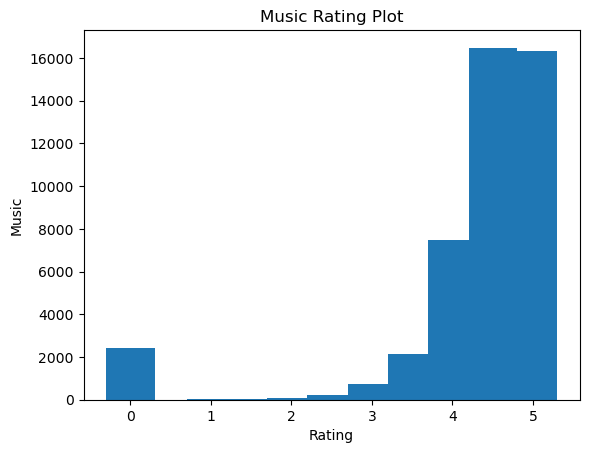

In [23]:
plt.title("Music Rating Plot")
plt.xlabel("Rating")
plt.ylabel("Music")
plt.bar(dict(df_music['rating'].value_counts()).keys(), dict(df_music['rating'].value_counts()).values(), width=0.6);

In [24]:
df_graph.shape

(1231437, 2)

nodes related to the books

In [25]:
df_graph_books = df_graph[
    df_graph.source.isin(df_books.id) & 
    df_graph.destination.isin(df_books.id)
]

In [26]:
df_graph_books.head()

,source,destination
39,12,386032
92,33,119026
103,39,150250
104,39,412517
105,39,517966


In [27]:
graph_book_indegree = df_graph_books.groupby(['destination'])['source'].size().reset_index(name='in_degree')

In [28]:
graph_book_outdegree = df_graph_books.groupby(['source'])['destination'].size().reset_index(name='out_degree')

In [29]:
print(f"the in_degree is in the range of {graph_book_indegree['in_degree'].min()} and {graph_book_indegree['in_degree'].max()}")

the in_degree is in the range of 1 and 82


In [30]:
print(f"the out_degree is in the range of {graph_book_outdegree['out_degree'].min()} and {graph_book_outdegree['out_degree'].max()}")

the out_degree is in the range of 1 and 5


getting the top-10 books 

In [31]:
temp_1 = graph_book_outdegree.set_index('source')
temp_2 = graph_book_indegree.set_index('destination').rename_axis('source')
temp_2.columns = temp_1.columns

merged = temp_2.add(temp_1, fill_value=0).loc[temp_2.index, :].reset_index()

In [32]:
for _, row in merged.nlargest(10, 'out_degree').iterrows():
    title = df.loc[df['id'] == int(row['source']), 'title'].iloc[0]
    
    print(f"Title: {title}")
    print(f"Outdegree: {row['out_degree']}")
    print("#-----------------------------")


Title: The Great Gatsby
Outdegree: 87.0
#-----------------------------
Title: Diagnostic and Statistical Manual of Mental Disorders DSM-IV-TR (Text Revision) (Diagnostic and Statistical Manual of Mental Disorders)
Outdegree: 74.0
#-----------------------------
Title: Brown Bear  Brown Bear  What Do You See?
Outdegree: 74.0
#-----------------------------
Title: Fireflies (Reading Rainbow)
Outdegree: 62.0
#-----------------------------
Title: The Catcher in the Rye
Outdegree: 61.0
#-----------------------------


In [33]:
df_graph_books_final = df_graph_books.groupby(['source','destination']).size().reset_index(name='occurance')
df_graph_books_final.head()

,source,destination,occurance
0,12,386032,1
1,33,119026,1
2,39,150250,1
3,39,412517,1
4,39,438351,1


In [34]:
nx_graph = nx.from_pandas_edgelist(
    df_graph_books_final, 'source', 'destination', ['occurance']
)

Analyzing the graph  
graph is disconnected beacuse we took a subset

In [35]:
num_nodes = nx_graph.number_of_nodes()
num_edges = nx_graph.number_of_edges()
print(f"graph has {num_nodes} nodes and {num_edges} edges")

graph has 45890 nodes and 92249 edges


In [36]:
nx.is_connected(nx_graph)

False

In [37]:
nx.density(nx_graph)

8.761228579935094e-05

In [38]:
num_connected_comps = nx.number_connected_components(nx_graph)
print(f"graph has {num_connected_comps} connected components")

graph has 2766 connected components


### Centrality Analysis
**Degree Centrality**

In [39]:
dc = nx.degree_centrality(nx_graph)

In [40]:
sorted_dc = sorted(dc.items(), key=operator.itemgetter(1), reverse=True)

In [41]:
df = pd.DataFrame(columns=["Attribute", "Node", "Centrality Value"])
df.loc[len(df)] = ["Highest Degree Centrality", sorted_dc[0][0], sorted_dc[0][1]]
print(df)

                   Attribute    Node  Centrality Value
0  Highest Degree Centrality  199628          0.001787


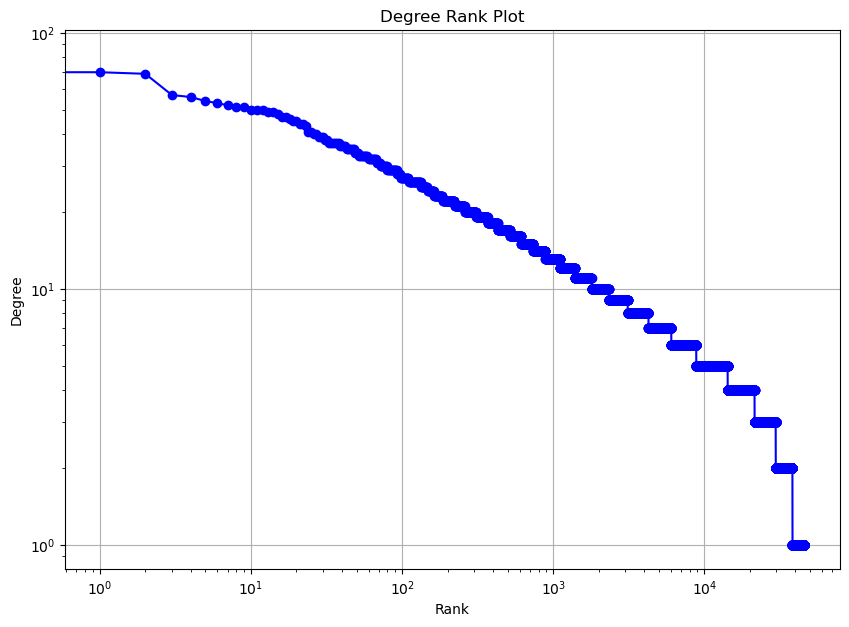

In [42]:
degree_sequence = sorted(dict(nx.degree(nx_graph)).values(), reverse=True)
plt.figure(figsize=(10,7))
plt.loglog(degree_sequence, 'b-', marker='o')
plt.title('Degree Rank Plot')
plt.ylabel('Degree')
plt.xlabel('Rank')
plt.grid()
plt.show()

"""
    Takes in a graph and returns a numpy array of node-degree distribution 
    in sorted format.

    Returns:
    --------
    numpy array:
        A 2D numpy array where each row represents a degree value and its frequency
        in the input graph, sorted by ascending degree values.
        The first column represents degree values, and the second column represents
        the frequency of nodes with that degree value.
    """


In [43]:
def get_degree_distribution(graph):
    degree_dist = dict(nx.degree(graph))
    degree_counts = Counter(degree_dist.values())
    sorted_degree_counts = sorted(degree_counts.items(), key=lambda item: item[0])
    degree_dist_array = np.array(sorted_degree_counts)
    return degree_dist_array


In [44]:
degree_distb_graph = get_degree_distribution(nx_graph)

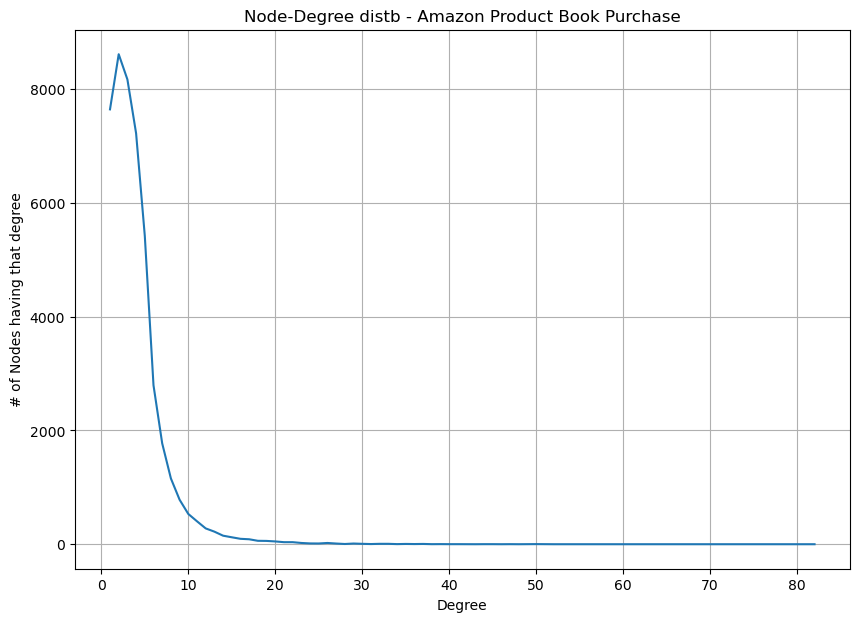

In [45]:
plt.figure(figsize=(10,7))
plt.plot(degree_distb_graph[:,0], degree_distb_graph[:,1])
plt.xlabel("Degree")
plt.ylabel(f"# of Nodes having that degree")
plt.title(f"Node-Degree distb - Amazon Product Book Purchase")
plt.grid()
plt.show()

graph shows a heavy-tail or right-skewed distribution, which follows a power law

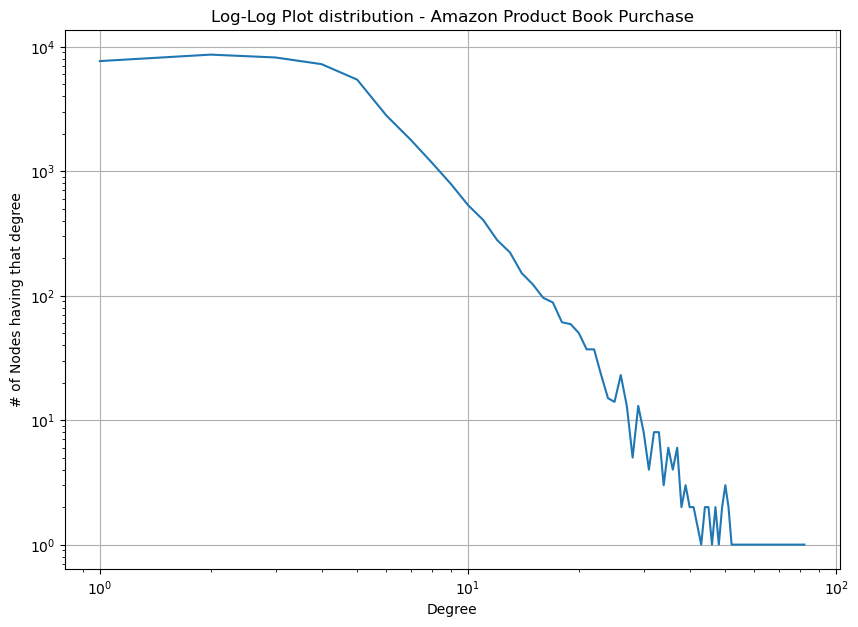

In [46]:
plt.figure(figsize=(10,7))
plt.loglog(degree_distb_graph[:, 0], degree_distb_graph[:, 1])
plt.xlabel("Degree")
plt.ylabel(f"# of Nodes having that degree")
plt.title(f"Log-Log Plot distribution - Amazon Product Book Purchase")
plt.grid()
plt.show()

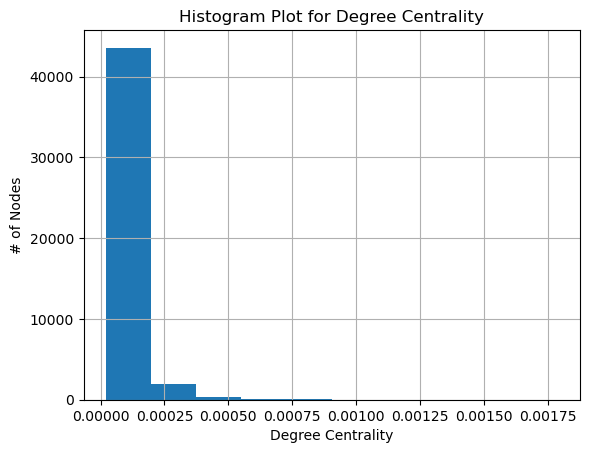

In [47]:
plt.title("Histogram Plot for Degree Centrality")
plt.xlabel("Degree Centrality")
plt.ylabel("# of Nodes")
plt.grid()
plt.hist(dc.values());

In [48]:
largest_component = nx.node_connected_component(nx_graph, 199628)
# sub_graph = nx_graph.subgraph(largest_component)
# position = nx.kamada_kawai_layout(sub_graph)

In [49]:
sub_graph = nx_graph.subgraph(largest_component)

In [50]:
# position = nx.kamada_kawai_layout(sub_graph)

In [51]:
# colormap = plt.cm.get_cmap('Spectral')

node_degrees = dict(sub_graph.degree())
nodes = dict(sub_graph.nodes())
node_colors = np.asarray([node_degrees[n] for n in nodes ])
node_edges = dict(sub_graph.edges())
node_weights = [sub_graph[s][d]['occurance'] for s, d in node_edges]

In [52]:
colors = range(87)
vmin,vmax = min(colors), max(colors)

In [ ]:
picture = nx.draw_kamada_kawai(
    sub_graph,
    k = 1.2,
    with_labels = False,
    nodelist = node_degrees.keys(),
    node_size = [vertex * 30 for vertex in node_degrees.values()],
    cmap = plt.cm.get_cmap('Spectral'),
    width = node_weights,
    arrows = True,
    node_color = node_colors,
    vmin = vmin,
    vmax = vmax
)

In [ ]:
fig, ax = subplots()
plt.xticks(list(), list())
plt.yticks(list(), list())
flg = plt.gcf()
fig.set_size_inches(50, 50)
scalar_map = plt.cm.ScalarMappable(
    cmap = plt.cm.get_cmap('Spectral'),
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
)
scalar_map._A = []

colorbar = plt.colorbar(scalar_map, aspect = 40)
colorbar.ax.tick_params(labelsize = 30)
plt.figure(dpi = 1200)
plt.show()

In [ ]:
degree_seq = [deg for nod, deg in sub_graph.degree()]
degree_seq.sort(reverse=True)

degree_count = Counter(degree_seq)

degr, count = zip(*degree_count.items())

fig, ax = plt.subplots()
plt.bar(degr, count, width=0.7, color='g')

plt.title("Histogram for Node Deg distb")
plt.ylabel("Node Count")
plt.xlabel("Node Degree")
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.show()

In [ ]:
sub_graph_density = nx.density(sub_graph)
(f"the sub graph density is {sub_graph_density}")

In [ ]:
sub_graph_deg_centrality = nx.degree_centrality(sub_graph)

In [ ]:
degree_distb_sub_graph = get_degree_distribution(sub_graph)
plt.figure(figsize=(10,7))
plt.plot(degree_distb_sub_graph[:,0], degree_distb_sub_graph[:,1])
plt.xlabel("Degree")
plt.ylabel(f"# of Nodes having that degree")
plt.title(f"Node-Degree distb - Amazon Product Book Purchase for Prominent Book")
plt.grid()
plt.show()

In [ ]:
social_dendrogram = community.generate_dendrogram(sub_graph)
print(f"Number of levels in the Dendrogram: {len(social_dendrogram)}")

In [ ]:
#  reference - referred the ipynb given by professor for drawing the dendrogram
def draw_dendrogram(dendrogram):
    digraph = nx.DiGraph()
    last_part = None
    
    for level_idx, part in enumerate(dendrogram):
        print(f"Level: {level_idx}, Num nodes in level: {len(part)}")
        
        for node, comunity in part.items():
            naming = f"l={level_idx}_{comunity}"
            digraph.add_node(naming, comm=comunity, color=level_idx+1)
            
            if level_idx == 0:
                digraph.add_node(node, comm=comunity, color=0)
                digraph.add_edge(naming, node)
            else:
                digraph.add_edge(naming, f"l={level_idx-1}_{node}")
        last_part = part
        
    plt.figure(figsize=(15, 10))
    
    colors = list(nx.get_node_attributes(digraph, "color").values())
    
    layout = graphviz_layout(digraph, prog="dot")
    nx.draw(digraph, layout, with_labels=True, arrows=False, node_color=colors,
           vmin=0, vmax=len(dendrogram)+1, cmap=plt.cm.tab20)

In [ ]:
# draw_dendrogram(social_dendrogram)